In [1]:
# %pip install numpy
# %pip install pandas
# %pip install ipywidgets
# %pip install torch
# %pip install torchvision
# %pip install scikit-learn
# %pip install tensorflow
# %pip install pennylane
# %pip install opencv-python
# %pip install matplotlib
# %pip install seaborn
# %pip install kagglehub
# %pip install monai

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from monai.transforms import ScaleIntensity
import kagglehub
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, random_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

import pennylane as qml
from pennylane import numpy as np

import warnings
warnings.filterwarnings("ignore")

Download latest version https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data

In [3]:
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")
dataset_path_train = f'{path}/Training'
dataset_path_test = f'{path}/Testing'
img_size = (224, 224)
class_names = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
samples_per_class = 2000

Check data

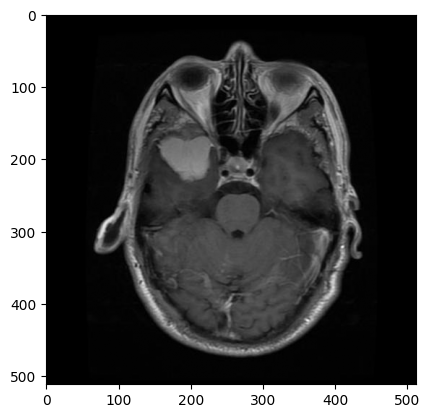

In [4]:
brain_image = cv2.imread(f'{dataset_path_train}/meningioma_tumor/m1(39).jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(brain_image, cmap='gray')

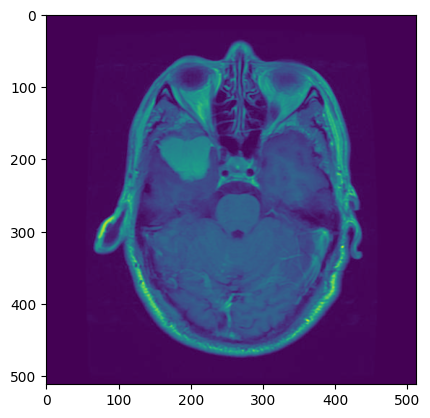

In [5]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
brain_image_scaled = transform_img(brain_image)
colored_kid = cm.viridis(brain_image_scaled)
plt.imshow(colored_kid)

Augmentation for training and testing

In [6]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

label_encoder = LabelEncoder()

Load and preprocess the images

In [7]:
def load_images_from_folder(folder, label, transform):
    data, labels = [], []
    for img_name in os.listdir(folder):
        try:
            img_path = os.path.join(folder, img_name)
            img = Image.open(img_path).convert("RGB")
            img = transform(img)
            data.append(img)
            labels.append(label)
        except Exception as e:
            print(f"[Warning] Error loading {img_path}: {e}")
    return data, labels

def load_dataset(dataset_path, transform, limit_per_class=None):
    X_all, y_all = [], []
    for class_name in class_names:
        folder = os.path.join(dataset_path, class_name)
        X_class, y_class = load_images_from_folder(folder, class_name, transform)
        if limit_per_class and len(X_class) > 0:
            X_class, y_class = resample(X_class, y_class, replace=True, n_samples=limit_per_class, random_state=42)
        X_all.extend(X_class)
        y_all.extend(y_class)
    label_encoder.fit(y_all)
    y_encoded = label_encoder.transform(y_all)
    return torch.stack(X_all), torch.tensor(y_encoded)

In [8]:
X_train, y_train = load_dataset(dataset_path_train, train_transform, samples_per_class)
X_test, y_test = load_dataset(dataset_path_test, test_transform, samples_per_class // 2)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: torch.Size([8000, 3, 224, 224]) torch.Size([8000])
Test set: torch.Size([4000, 3, 224, 224]) torch.Size([4000])


Display images for train

Found 2870 validated image filenames belonging to 4 classes.


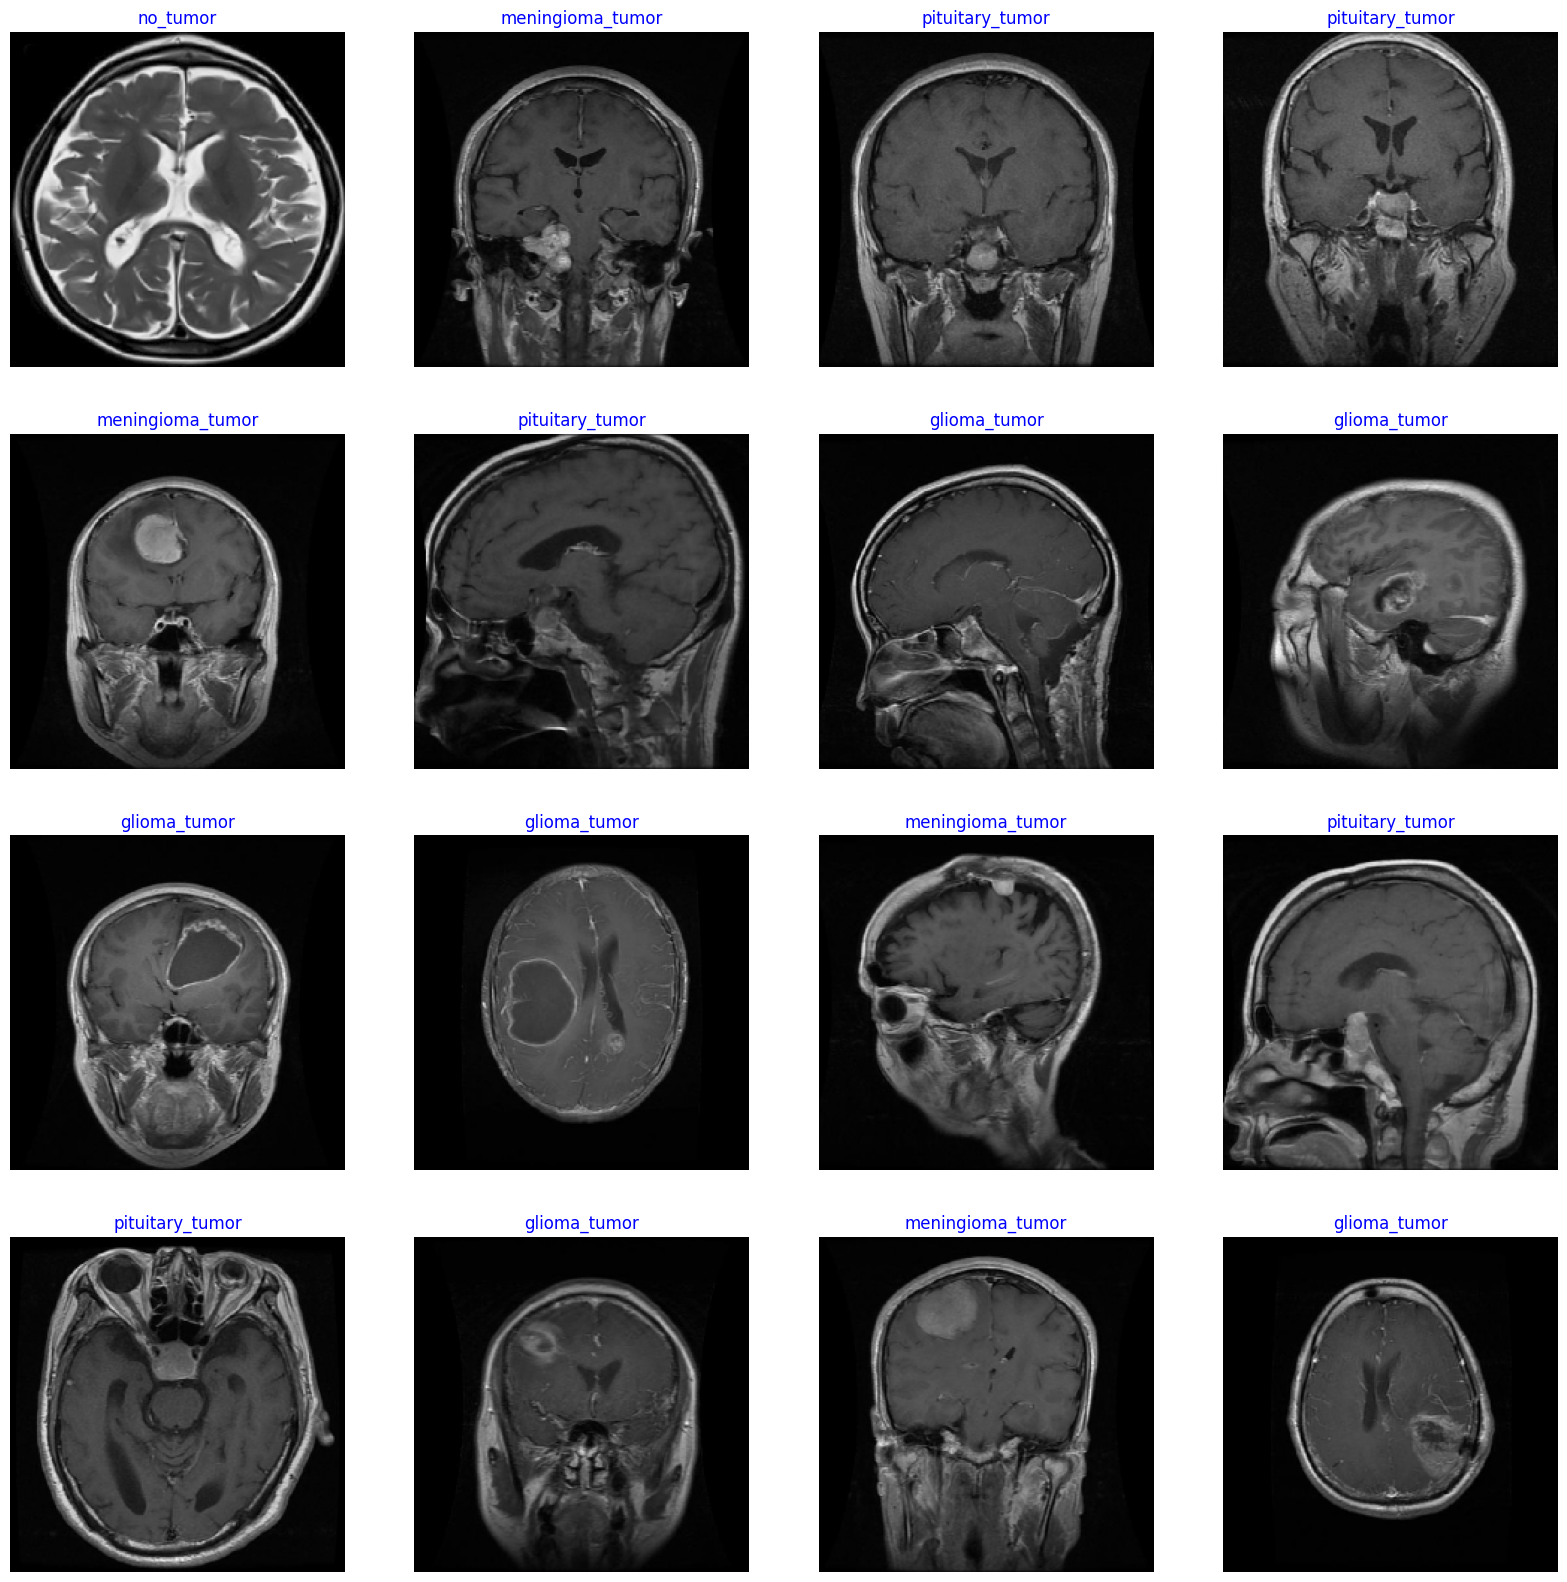

In [9]:
def create_dataframe_from_directory(directory, class_names):
    data = []
    for label in class_names:
        folder = os.path.join(directory, label)
        if not os.path.exists(folder):
            continue
        for fname in os.listdir(folder):
            if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                filepath = os.path.join(folder, fname)
                data.append({'filepaths': filepath, 'labels': label})
    return pd.DataFrame(data)

train_df = create_dataframe_from_directory(dataset_path_train, class_names)
train_df = train_df.sample(frac=1).reset_index(drop=True)

def scalar(img):
    return img

batch_size = 32

tr_gen = ImageDataGenerator(preprocessing_function=scalar)

train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

g_dict = train_gen.class_indices     
classes = list(g_dict.keys())       
images, labels = next(train_gen)      

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255.0
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

Convert to tensors

In [10]:
class_indices = label_encoder.transform(class_names)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_indices,
    y=y_train.numpy()
)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

counts = np.bincount(y_train.numpy(), minlength=len(class_names))
counts[counts == 0] = 1  # prevent division by zero
weights = 1. / counts
samples_weights = torch.from_numpy(weights[y_train.numpy()]).double()
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Visualize class distribution

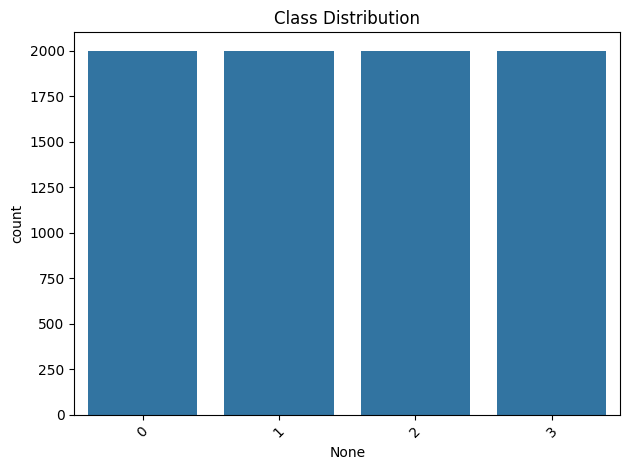

In [11]:
sns.countplot(x=y_train)
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.tight_layout()
plt.show()

Set device to CPU

In [12]:
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


Set up PennyLane device

In [13]:
qdevice = qml.device("default.qubit", wires=6)

Quantum circuit definition

In [14]:
@qml.qnode(qdevice, interface="torch")
def quantum_circuit(inputs, weights):
    for i in range(6):
        qml.RY(inputs[i % len(inputs)], wires=i)
    qml.templates.BasicEntanglerLayers(weights, wires=range(6))
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

q_shapes = {"weights": (4, 6)}
quantum_layer = qml.qnn.TorchLayer(quantum_circuit, q_shapes).to(device)

Matplotlib is building the font cache; this may take a moment.


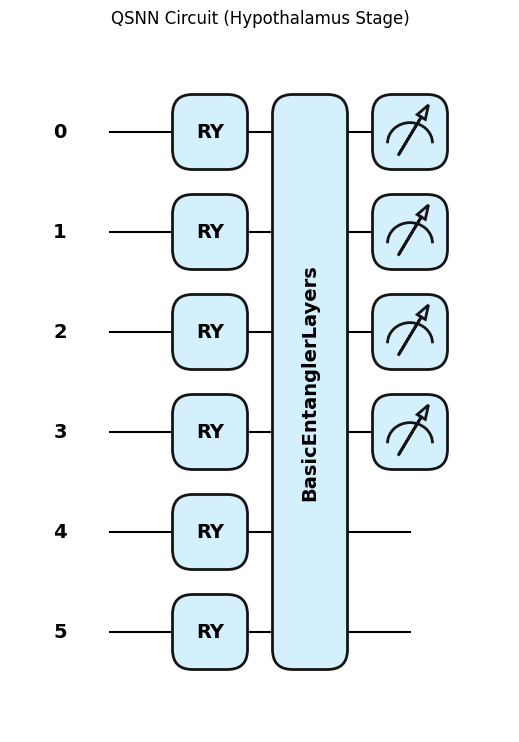

In [15]:
dummy_input = torch.tensor([0.1, 0.2, 0.3, 0.4], requires_grad=False)
dummy_weights = torch.rand(q_shapes['weights'])
qml.draw_mpl(quantum_circuit, style="pennylane")(dummy_input, dummy_weights)
plt.title("QSNN Circuit (Hypothalamus Stage)")
plt.show()

Quantum-enhanced ResNet classifier

In [16]:
class QuantumResNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Identity()
        self.fc1 = nn.Linear(512, 6)
        self.quantum = quantum_layer
        self.fc2 = nn.Linear(4, 4)

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc1(x)
        x = torch.stack([self.quantum(sample) for sample in x])
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Label smoothing

In [17]:
class LabelSmoothingNLLLoss(nn.Module):
    def __init__(self, smoothing=0.1, weight=None):
        super().__init__()
        self.smoothing = smoothing
        self.weight = weight

    def forward(self, pred, target):
        confidence = 1.0 - self.smoothing
        logprobs = pred
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        if self.weight is not None:
            nll_loss = nll_loss * self.weight[target]
            smooth_loss = smooth_loss * self.weight[target]
        return (confidence * nll_loss + self.smoothing * smooth_loss).mean()

Training function

In [18]:
def train_model(model, loader, epochs=5, patience=3):
    model.to(device)
    train_size = int(0.9 * len(loader.dataset))
    val_size = len(loader.dataset) - train_size
    train_data, val_data = random_split(loader.dataset, [train_size, val_size])
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
    criterion = LabelSmoothingNLLLoss(smoothing=0.1, weight=class_weights.to(device))
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)
        for X_batch, y_batch in loop:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            out = model(X_batch)
            loss = criterion(out, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == y_batch).sum().item()
            total += y_batch.size(0)
            loop.set_postfix(loss=loss.item(), acc=correct/total)

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                out = model(X_val)
                val_loss += criterion(out, y_val).item()
                pred = out.argmax(dim=1)
                val_correct += (pred == y_val).sum().item()

        val_acc = val_correct / len(val_data)
        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break

Evaluation


--- Training Quantum + ResNet Model ---


Epoch 1, Val Loss: 1.2632, Val Acc: 0.4838


Epoch 2, Val Loss: 1.1967, Val Acc: 0.6000


Epoch 3, Val Loss: 1.0764, Val Acc: 0.7250


Epoch 4, Val Loss: 0.9728, Val Acc: 0.8750


Epoch 5, Val Loss: 0.8897, Val Acc: 0.9237
Accuracy: 0.56025
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.85      0.24      0.37      1000
meningioma_tumor       0.86      0.45      0.59      1000
        no_tumor       0.38      1.00      0.55      1000
 pituitary_tumor       0.97      0.55      0.70      1000

        accuracy                           0.56      4000
       macro avg       0.76      0.56      0.55      4000
    weighted avg       0.76      0.56      0.55      4000



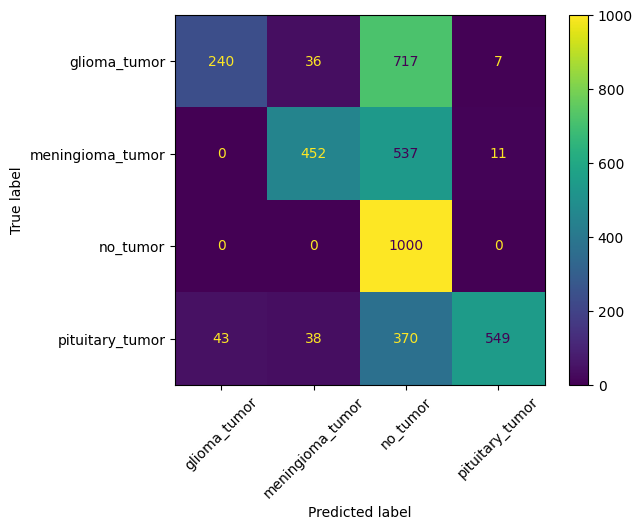

In [19]:
def evaluate_model(model, loader):
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            out = model(X_batch)
            pred = out.argmax(dim=1).cpu().numpy()
            y_pred.extend(pred)
            y_true.extend(y_batch.numpy())
    print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
    print("Classification Report:\n", metrics.classification_report(y_true, y_pred, target_names=class_names))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=class_names, xticks_rotation=45)
    plt.show()

model = QuantumResNetClassifier()
print("\n--- Training Quantum + ResNet Model ---")
history = train_model(model, train_loader)
evaluate_model(model, test_loader)

#### Predicted probability for Positive Class

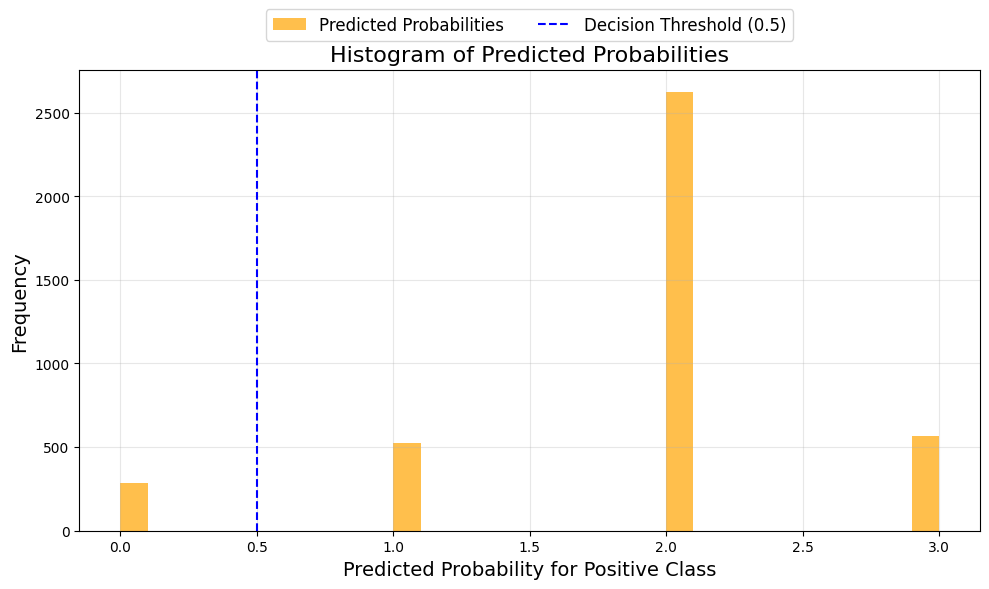

In [25]:
y_pred_probabilities_tensor = torch.tensor(y_pred, dtype=torch.float32)

y_pred_positive_probs = y_pred_probabilities_tensor

predictions = torch.round(y_pred_positive_probs)

plt.figure(figsize=(10, 6))

plt.hist(
    y_pred_positive_probs.numpy(),
    bins=30,
    alpha=0.7,
    color='orange',
    label='Predicted Probabilities'
)

plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)

plt.title('Histogram of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability for Positive Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### PCA of model prediction

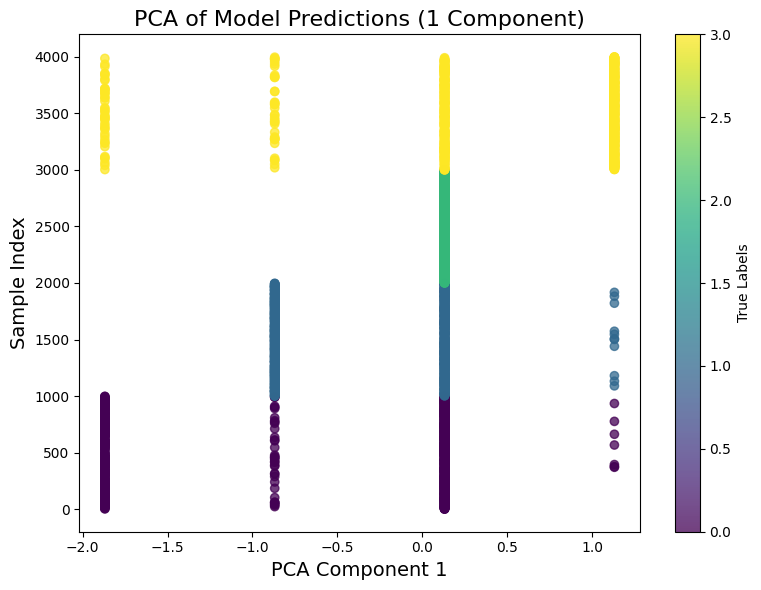

In [26]:
if y_test.ndim > 1:
    y_test_labels = torch.argmax(torch.tensor(y_test), dim=1).numpy()
else:
    y_test_labels = torch.tensor(y_test).numpy()

labels_test_reshaped = y_pred.reshape(-1, 1)
pca = PCA(n_components=1)
features_pca = pca.fit_transform(labels_test_reshaped)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], range(len(features_pca)), c=y_test_labels, cmap='viridis', alpha=0.75)

plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)

plt.tight_layout()
plt.show()